# Exercise 7: Sinusoidal plus residual model

In this exercise you will analyze and synthesize sounds using the Harmonic plus Stochastic (HPS) model, `hpsModel.py`. There are two questions in this exercise. In the first one you will analyze a speech sound that we give and in the second one you will analyze a sound of your choice, in both cases using the HPS model. For each question, you will first describe some of the sound characteristics by listening to the sounds and visualizing their spectrogram, characteristics that should be of relevance for the analysis/synthesis with the HPS model. Then from the described characteristics you will set the appropriate values for the different analysis parameters, explaining the choices you make, and analyze and synthesize the sounds with the HPS model software.

For this exercise, you can use `models_GUI.py`, to experiment with the parameters easily and then use them in here. Feel free to modify the code of the model if needed and add it also here. 

To help you with the exercise, we first give a brief description of the analysis parameters used by the HPS model function:

1. Window type (`window`) and Window size (`M`): The choice of window size and window type has a time-frequency trade-off. Choosing a longer window helps resolve sinusoidal components that are close in frequency, but gives a poorer temporal resolution. Shorter windows track transients better, maintaining sharp onsets, but may not resolve frequency components so well. For monophonic harmonic sounds, the window size is best chosen based on the lowest value of f0 and the fastest change in pitch.
2. FFT size (`N`): The FFT size is chosen as a power of 2 larger than the window size M. A large FFT size N, compared with M, results on an interpolated DFT spectrum and leads to better estimation of spectral peak values. However, given that the software also uses parabolic interpolation we can achieve good peak estimates with not too big FFT sizes, for example just the next power of 2 larger than M.
3. Threshold in negative dB (`t`): The peak picking threshold is the lowest amplitude peak that will be identified. Setting a very low threshold ($<-120$dB) will take most peaks, but the threshold should be set as high as possible to minimize the presence of peaks that do not correspond to sinusoidal peaks (the window main-lobe).
4. Maximum number of harmonics (`nH`): The maximum number of harmonics that can be detected in a harmonic sound is influenced by the brightness of the sound, but also by the sampling rate and by how low is the f0. The recording quality can also have an impact. For a compact representation, we should only capture the relevant harmonics, the ones that affect the perceptual quality of the reconstruction.
5. Minimum f0 frequency in Hz (`minf0`) and Maximum f0 frequency in Hz (`maxf0`): The `minf0` and `maxf0` are the parameters used by the fundamental frequency detection algorithm to obtain possible `f0` candidates to be passed to the TWM algorithm. Choosing a correct range of `f0`, but the smallest possible, greatly improves the `f0` estimation by TWM algorithm, specially minimizing octave errors, which are very common in `f0` detection algorithms. You should select the values by first looking at the spectrogram of the sound and identifying the lowest and highest fundamental frequencies present.
6.  Threshold in the f0 detection (`f0et`): This is the maximum error allowed in the TWM algorithm. If the value is too large, the algorithm might detect fundamental frequencies that might not be actually so. Instead, if is it too small, good fundamental frequencies might not be detected, returning value 0 at that frame. The smaller the value the more restrictive the algorithm behaves. A normal strategy is to start with a big value ($> 10$) and then making it smaller until we only keep what we consider to be the relevant f0 components, discarding the \text{f0} values in the parts of the sound that do not have a clear harmonic structure.
7. Slope of harmonic deviation (`harmDevSlope`): Slope of the harmonic deviation allowed in the estimated harmonic frequencies, compared to a perfect harmonic frequencies. If the value is 0 it means that we allow the same deviation for all harmonics, which is hard coded to \texttt{f0}$/3$. A value bigger than 0 means that higher harmonics will be allowed to deviate more than the lower harmonics from perfect harmonicity (which is a common behaviour). It normally works better to have a value slightly bigger than 0, for example around 0.01.
8. Minimum length of harmonics (`minSineDur`): Any harmonic track shorter, in seconds, than minSineDur will be removed. This is a good parameter for discarding harmonic tracks that are too short and thus that do not correspond to stable harmonics of the sound. Typically we put a value bigger that 0.02 seconds.
9. Decimation factor of magnitude spectrum for stochastic analysis (`stocf`): The stochastic approximation of the residual is a decimated version of the magnitude spectrum of the residual. This leads to a compact and smooth function that approximates the magnitude spectrum of the residual at each frame. The smaller the stocf, higher the decimation will be and thus will result in a more compact representation. A value of 1 means no decimation, leaving the residual magnitude spectrum as it is. A value of 0.2 (a good starting value) will decimate the original residual magnitude spectrum by a factor of 1/5.

The most compact and useful representation of a sound, least number of analysis data values while maintaining the sound quality in the synthesis, will be obtained by using a high t, a small `nH`, a small decimation factor for stochastic analysis, stocf, and by succeeding in detecting only the harmonics they are perceptually relevant. The values of `nH`, `minf0` and `maxf0` should be chosen by first visualizing the spectrogram of the sound with a large enough window size. There is usually a range of all parameter values for which we get a good reconstruction. Also the analysis parameters are not independent of each other and hence they need to be considered together. For testing if the detection of the harmonics have been done correctly (and for improving it) it is very useful to perform the Harmonic plus Residual analysis/synthesis (HPR model) using the same parameters and listen to the residual component for possible artifacts resulting from the harmonic analysis.

## Part 1. Obtain a good harmonic+stochastic analysis of a speech sound

Analyze and synthesize the `sound speech-female.wav`, available from the sounds directory, using `hpsModelAnal()` and `hpsModelSynth()` from the `hpsModel.py` module. The goal is to obtain the best possible reconstruction using the most compact representation. Perform the following two tasks:

1. Analyze the sound with the STFT using `models-GUI.py`, or with any other analysis tool you might wish, and describe the characteristics of the sound that might be relevant to perform the HPS analysis. Specially important characteristics for the analysis include pitch range and maximum number of harmonics. Explain the sound: write no more than a paragraph for this description.
2. Select the analysis parameters that give a good reconstruction and at the same time result in the most compact representation possible, specially related to the number of harmonics and the number of stochastic coefficients. We recommend that you first perform the harmonic plus residual analysis and by listening to the residual make some decisions on the best parameters to use. You can listen to the output sounds (harmonic, residual, stochastic components) and fine tune the parameters. Save the output sounds. Explain the choices for the following parameters: window type, window size, FFT size, minimum f0, _maximum f0, error threshold in f0 detection, number of harmonics, and stochastic decimation factor. Explain the analysis: in your descriptions do not use more than one sentence per parameter.

__Example:__ example of an analysis/synthesis for a male speech sound:

1. Input sound: http://freesound.org/people/xserra/sounds/317744/
2. Harmonic component: http://freesound.org/people/xserra/sounds/327139/
3. Residual component: http://freesound.org/people/xserra/sounds/327141/
4. Stochastic component: http://freesound.org/people/xserra/sounds/327137/
5. Harmonic+stochastic resynthesis: http://freesound.org/people/xserra/sounds/327140/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window
import sys, os
sys.path.append('../software/models/')
import utilFunctions as UF
import stft as STFT
import hpsModel as HPS
import IPython.display as ipd

Text(0.5,1,'magnitude spectrogram')

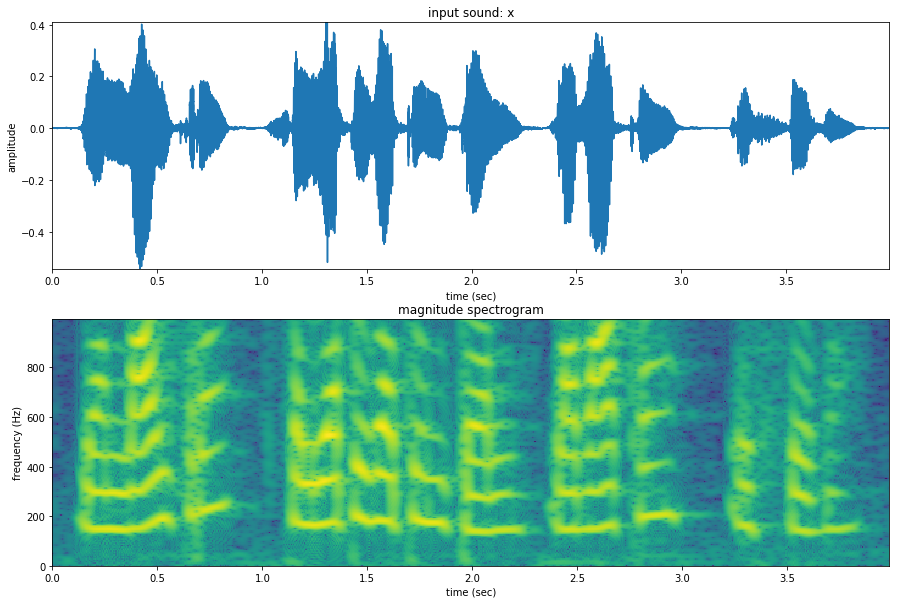

In [2]:
# basic visualization and listening of sound
input_file = '../sounds/speech-female.wav'

### set parameters
window = 'hamming'
M = 4095
N = 8192
H = 256

    
# no need to modify anything after this
fs, x = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
mX, pX = STFT.stftAnal(x, w, N, H)

ipd.display(ipd.Audio(data=x, rate=fs))

plt.figure(figsize=(15, 10))
maxplotfreq = 1000.0

# plot input sound
plt.subplot(2,1,1)
plt.plot(np.arange(x.size)/float(fs), x)
plt.axis([0, x.size/float(fs), min(x), max(x)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('input sound: x')

# plot magnitude spectrogram
plt.subplot(2,1,2)
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.title('magnitude spectrogram')

In [6]:
4*44100/150

1176.0

### 1.1 Describe sound

Large deviations in f0 (highest point of f0 (0.8s) nearly reaches the f1 of other parts.)
Strong presence of inharmonics at consonants, like t,r,sh sounds.


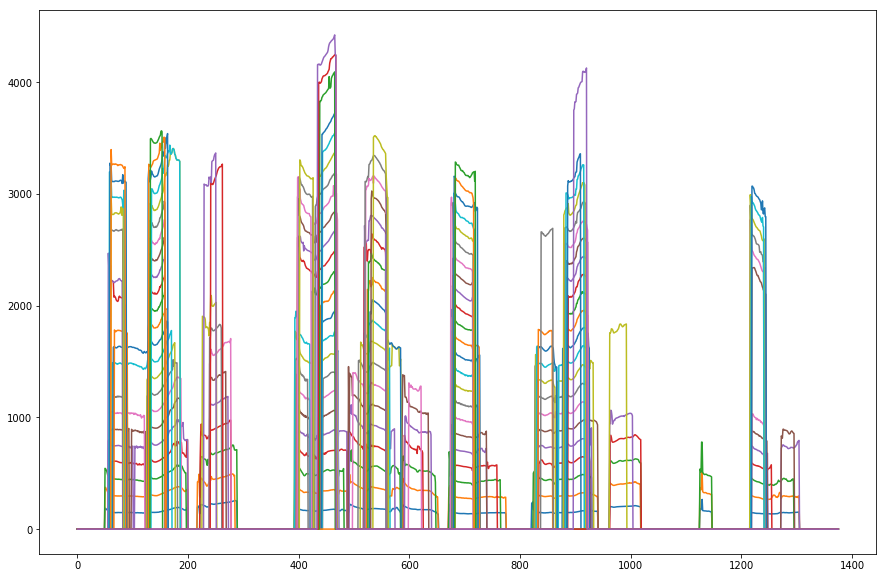

In [26]:
# analysis and synthesis of sound using the HPS model
input_file = '../sounds/speech-female.wav'

### fill the parameters
window ='hamming'
M = 1201
N = 4096
t = -62.5
minSineDur = 0.065
nH = 25
minf0 = 130
maxf0 = 280
f0et = 7
harmDevSlope = 0.01
stocf = 0.6

# no need to modify anything after this
Ns = 512
H = 128

(fs, x) = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H, fs)

plt.figure(figsize=(15, 10))
plt.plot(np.arange(hfreq.shape[0]),hfreq)
ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))
ipd.display(ipd.Audio(data=yh, rate=fs))
ipd.display(ipd.Audio(data=yst, rate=fs))       

### 1.2 Explain the analysis

I tried to keep harmonic sound as clean as possible while synth still sound decent. Keeping 's' sound (last word) in residual while keeping vowels bright(with more harmoncs) was hard. 
The 's' sound has higher magnitude than 'e' sound that comes before 's'. Also 'e' has higher f0 deviation somehow. So dB threshold and f0et did not help to seperate them.
Residual sounds are generally shorter in duration, I increased minSineDur as much as possible before losing the first vowel 'e' at last word.
Increasing stocf, helps with capturing high freq. sound into stochastic signal, increases the quality of consonant 's' especially. But since I keep threshold high as possible to keep yh clean, some lost harmonics can be perceived in yst with high stocf. It is a sacrifice to keep synth sound good.

## Part 2. Obtain a good harmonic+stochastic analysis of a monophonic musical phrase

Analyze and synthesize a harmonic sound of your choice from Freesound using the harmonic plus stochastic model. The goal is to obtain the best possible reconstruction using the most compact representation possible. Return an explanation of what you have done and why, together with the re-synthesized sounds.

The sound from freesound to use could be in any format, but to use the sms-tools software you will have to first convert it to be a monophonic file (one channel), sampling rate of 44100, and 16bits samples. You might also have to select a fragment of the sound.

_Part 2.1:_ Choose a sound from freesound to be analyzed, download it, and if necessary, edit it, and covert it to the right format. It should be a short monophonic musical fragment of a harmonic sound, not longer than 5 seconds. In the explanation add the freesound link of the sound selected and write a brief explanation of why you chose this sound.

_Part 2.2:_ Analyze the chosen sound with the STFT, or with any other analysis or tool you might wish, and describe the characteristics of the sound that will be relevant to perform the harmonic plus stochastic analysis. Important characteristics for the analysis include the pitch range and the maximum number of harmonics. Write no more than a paragraph.

_Part 2.3:_ Select the analysis parameters that give a good reconstruction and at the same time result in to the most compact representation, specially related to the number of harmonic and the number of stochastic coefficients. We recommend that you first perform the harmonic plus residual analysis and by listening to the residual make some decisions on the best parameters to use. You can listen to the output sounds (harmonic, residual, stochastic components) and fine tune the parameters. Save the output sounds. Explain the choices for the following parameters: window type, window size, FFT size, minimum f0, maximum f0, error threshold in f0 detection, number of harmonics, and stochastic decimation factor. In your descriptions do not use more than one sentence per parameter.

In [30]:
# 2.1 download the sound from freesound, read it with waveread

#### your code here
input_file = '../sounds/guitar_c_major_scale.wav'
(fs, x) = UF.wavread(input_file)
ipd.display(ipd.Audio(data=x, rate=fs))

### write a brief description of the sound
"""
https://freesound.org/people/svurucu/sounds/494364/

C major scale run, 1 octave, f0 range 130Hz-261Hz
I will try to capture the strike noises in stochastic signal.
Those noises are more present, when guitar player's fingers are not in direct angle with strings;
Nails sweep the string horizontally. Which creates that noise only present in upper strings of classical guitar;
Because of the metal coil they have. (notice that noise is not present in highest 3 notes, which are played 
at 3rd (G) string.)
Also, notice the loudness an brightness difference between odd and even strikes, 
caused from imbalance of two fingers, picking alternatively.

I chose to analyze this sound to understand more about problems we face at MusicCritic. 
I recorded this using my phone, records much better than my laptop. I think this is the general case.
Could we make students upload their exercises via their phone?
"""

'\n\n\n'

In [73]:
6*fs/27

9800.0

"c-d-e-f-g-A-b-c2-b-a-g-f-e-d-c\nNotice the reverb that begins with A. (220Hz) That reverb is caused by the resonance of the classic guitar. \nIt happens even though you stop the string immediately.\n\nA:220Hz is played shortly, at 3rd (g) string. only way to stop the reverb is to place hand on 5th string (A:110Hz),\nstring that amplifies the resonance.\n\nThat problem won't happen with e.g. D note; playing D one octave higher, will not start shaking D (4th) string,\nbecause body of the guitar absorbs that frequency.\n\nAlso notice, this problem does not happen when returning back, c2-b-a-g.. Because I'm playing with 'apoyando'\ntechnique, where my fingers touch the upper string after strokes;\nI play 'g' at 4th string, after 'a'. My finger rests at 5th string, stops the resonance. \n(does not stop entirely, because I wasn't paying attention to the technique, \nI was playing between 'apoyando' and 'tirando' (where your fingers does not touch the above string.)\n\nSo we need to select w

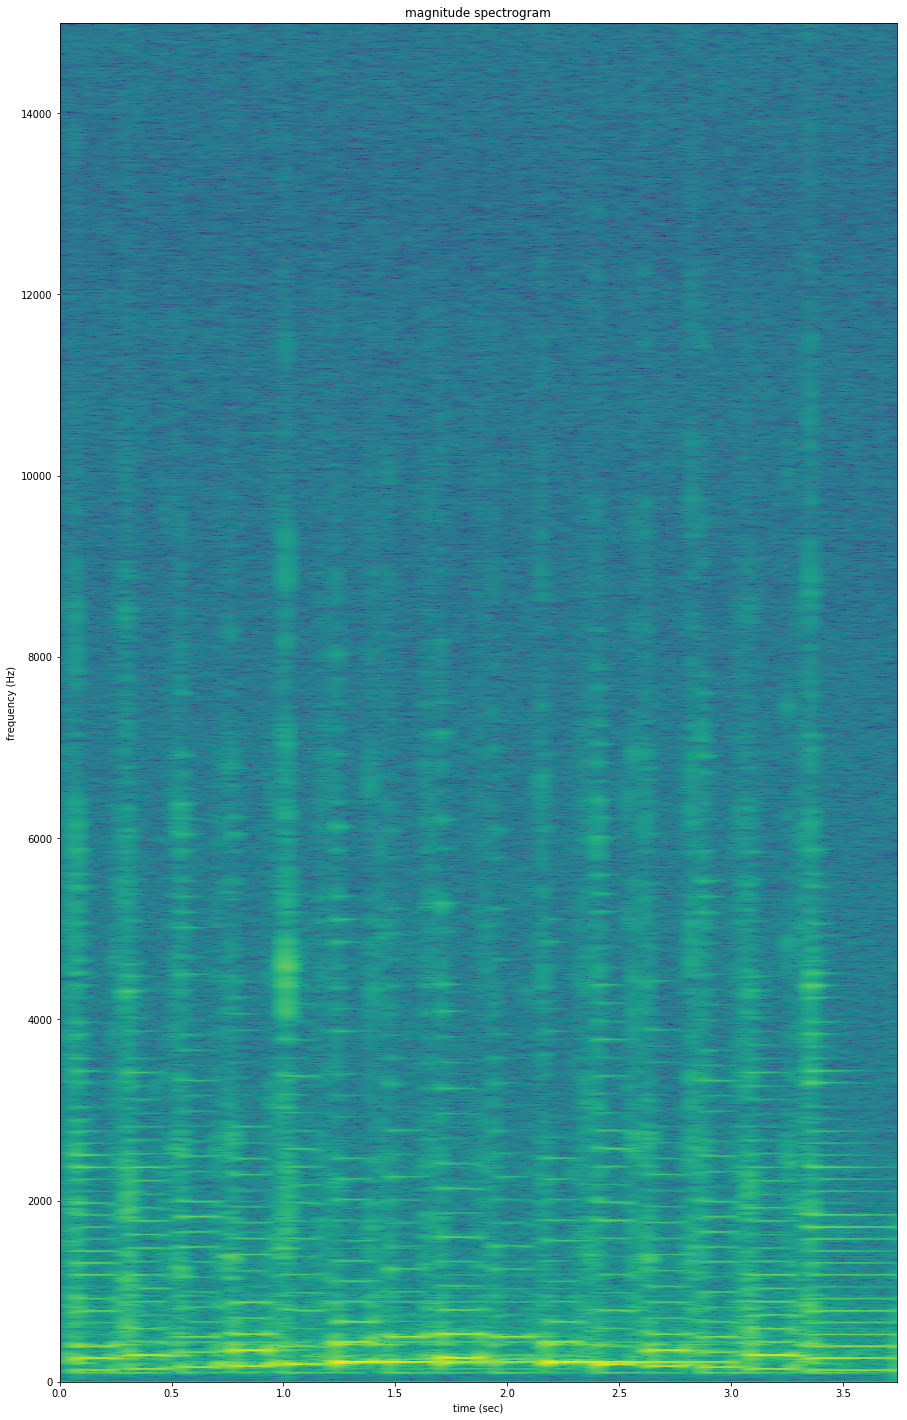

In [37]:
# Part 2.2 basic visualization and listening of sound

### basic visualization and listening of sound
input_file = '../sounds/guitar_c_major_scale.wav'
window = 'blackman'
M = 8001
N = 8192
H = 128

# no need to modify anything after here
fs, x = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
mX, pX = STFT.stftAnal(x, w, N, H)

ipd.display(ipd.Audio(data=x, rate=fs))

plt.figure(figsize=(15, 25))
maxplotfreq = 15000.0
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.title('magnitude spectrogram')

### describe the characteristics relevant to perform the harmonic plus stochastic analysis
"""
c-d-e-f-g-A-b-c2-b-a-g-f-e-d-c
Notice the reverb that begins with A. (220Hz) That reverb is caused by the resonance of the classic guitar. 
It happens even though you stop the string immediately.

A:220Hz is played shortly, at 3rd (g) string. only way to stop the reverb is to place hand on 5th string (A:110Hz),
string that amplifies the resonance.

That problem won't happen with e.g. D note; playing D one octave higher, will not start shaking D (4th) string,
because body of the guitar absorbs that frequency.

Also notice, this problem does not happen when returning back, c2-b-a-g.. Because I'm playing with 'apoyando'
technique, where my fingers touch the upper string after strokes;
I play 'g' at 4th string, after 'a'. My finger rests at 5th string, stops the resonance. 
(does not stop entirely, because I wasn't paying attention to the technique, 
I was playing between 'apoyando' and 'tirando' (where your fingers does not touch the above string.)

So we need to select window size according to difference between A-b, 247-220 = 27Hz
M = 6*fs/27 = 9800 (6k-8k would still be fine), other params for now;
N = 16384    , we lost the time res. with that M already. let's have some bins as redeem.
minSineDur = 0.15 ; around 4 notes per second, 0.2 might work but harmonics will die faster.
nH = 20 ; number of useful harmonics (by looking at stft) varies between 15-25, higher for low notes and vice versa
we know the f0 range already. I'll decide other params after experimenting
"""




'\nmission impossible.\nincreasing stocf helps with capturing high freq. noise\nWhen there is more than one harmonic, (resonance mentioned above), one of the harmonic series is not selected \nand it becomes noise at stochastic signal.\nTime resolution with this window size is tolerable. Doubling it (16k) will shift the perceived onsets randomly.\n\nthreshold is important to get rid of unwanted resonance. \nI did not observe much difference for different f0et, slope\nkeeping minSineDur low, does not make the problematic area worse while \nhelping with capturing more harmonics of all notes. \n'

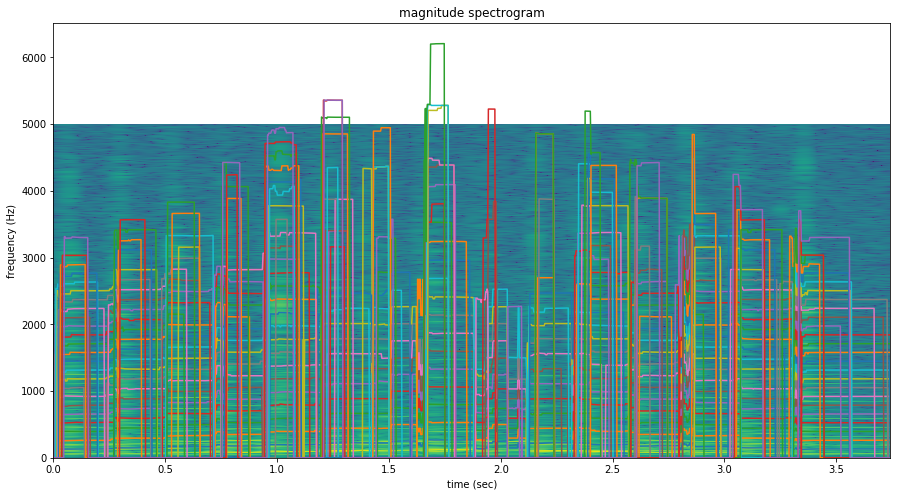

In [119]:
input_file =  '../sounds/guitar_c_major_scale.wav'
window ='blackman'
M = 8001
N = 16384
t = -79
minSineDur = 0.05
nH = 25
minf0 = 125
maxf0 = 270
f0et =10
harmDevSlope = 0.01
stocf = 0.8

# No need to modify
Ns = 512
H = 128

(fs, x) = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H, fs)

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))
ipd.display(ipd.Audio(data=yh, rate=fs))
ipd.display(ipd.Audio(data=yst, rate=fs))

plt.figure(figsize=(15, 8))
maxplotfreq = 5000.0
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))
plt.plot(frmTime,hfreq)
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.title('magnitude spectrogram')
### Explain the choices of parameters
"""
mission impossible.
increasing stocf helps with capturing high freq. noise
When there is more than one harmonic, (resonance mentioned above), one of the harmonic series is not selected 
and it becomes noise at stochastic signal.
Time resolution with this window size is tolerable. Doubling it (16k) will shift the perceived onsets randomly.

threshold is important to get rid of unwanted resonance. 
I did not observe much difference for different f0et, slope
keeping minSineDur low, does not make the problematic area worse while 
helping with capturing more harmonics of all notes. 
"""